Download torch and torchvision

In [1]:
# pip install torch
# pip install timm

In [2]:
# pip install torchvision

Initialization

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from transformers import Dinov2Model, AutoImageProcessor
from urllib.request import urlopen
from PIL import Image
import timm

In [2]:
from util import *

In [3]:
USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4080 is available.


If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [4]:
# data 
random_trans = [v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2)), 
                v2.RandomRotation(degrees=20),
                v2.RandomErasing(p=0.2, scale=(0.05, 0.2), ratio=(0.8, 1.2)), 
                v2.RandomGrayscale(),
                v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                v2.RandomHorizontalFlip(p=0.1)]

transform_train = v2.Compose([v2.ToImage(), 
                        v2.Resize(size=235, antialias=True),
                        v2.CenterCrop(size=(224, 224)),
                        v2.ToDtype(torch.float32, scale=True),
                        v2.RandomApply(random_trans, 0.5)])

transform_eval = v2.Compose([v2.ToImage(), 
                            v2.ToDtype(torch.float32, scale=True)])

In [5]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [6]:
# creat a dictionary that maps index to label
data_dir='../ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [7]:
button_train = CropButtonDataset('../ClassificationDataset_label/train', transform=transform_train)
loader_train = DataLoader(button_train, batch_size=64, shuffle=True)

button_val = CropButtonDataset('../ClassificationDataset_label/val', transform=transform_eval)
loader_val = DataLoader(button_val, batch_size=20, shuffle=False)

button_test = CropButtonDataset('../ClassificationDataset_label/test', transform=transform_eval)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Check If load correctly

In [8]:
loader_train

In [9]:
for images, labels in loader_val:
    print("Batch loaded!")
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break


Batch loaded!
Images shape: torch.Size([20, 3, 320, 320])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Model setup

In [10]:
class VitBinaryClassifier(nn.Module):
    def __init__(
        self,
        backbone_name: str = 'tiny_vit_21m_224.dist_in22k_ft_in1k',
        hidden_dim: int = 512,
        dropout_prob: float = 0.4,
    ):
        """
        Param:
            - backbone_name: Hugging Face Vit 
            - hidden_dim: hidden dim
            - dropout_prob: dropout ratio
        """
        super().__init__()
        # 1) data preprocessing (check next cell for deatils)
        self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=0)
        hidden_size = self.backbone.head.in_features

        # 2) Classification Head：CLS token -> hidden_dim -> ReLU -> Dropout
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),  # BCE 1 dim output
        )

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        """
        Param:
            - pixel_values: shape = (batch_size, 3, image_size, image_size),
        Output:
            - logits: shape = (batch_size, 2) raw score
        """
        # 1) Run backbone (e.g., TinyViT from timm), output shape: (B, seq_len, hidden_size)
        cls_token = self.backbone(pixel_values)

        # 2) Apply classifier head
        logits = self.classifier(cls_token)  # (B, 1)
        return logits  # squeeze to (B,)

test backbone

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model
model = VitBinaryClassifier().to(device)

dummy_images = torch.randn(2, 3, 224, 224).to(device)  # (B=2, C=3, H=224, W=224)

with torch.no_grad():
    logits = model(dummy_images)

print("Logits:", logits)
probs = torch.softmax(logits, dim=-1)
print("Probabilities:", probs)

Logits: tensor([[-0.4764],
        [-0.1923]], device='cuda:0')
Probabilities: tensor([[1.],
        [1.]], device='cuda:0')


Find best hyperparameter

In [12]:
# arch = ('tiny_vit_21m_224.dist_in22k_ft_in1k', 256, 0.5)
# best_model, best_params, best_training_data, top_5 = hyperparameter_search(VitBinaryClassifier, arch, loader_train, loader_val, device)

In [13]:
"""
Top 5 models by validation accuracy:
Rank 1: Acc=0.7000 | Params={'lr': 6.172920121930198e-06, 'weight_decay': 0.006545860661638547, 'betas': (0.9, 0.98)}
 Saved to top1_model.pt
Rank 2: Acc=0.6500 | Params={'lr': 8.697573560150729e-05, 'weight_decay': 0.0012040499297036793, 'betas': (0.9, 0.98)}
 Saved to top2_model.pt
Rank 3: Acc=0.6500 | Params={'lr': 2.5576493330770398e-06, 'weight_decay': 0.006545860661638547, 'betas': (0.9, 0.98)}
 Saved to top3_model.pt
Rank 4: Acc=0.6500 | Params={'lr': 0.0053144550285093494, 'weight_decay': 0.0012040499297036793, 'betas': (0.95, 0.999)}
 Saved to top4_model.pt
Rank 5: Acc=0.6500 | Params={'lr': 6.172920121930198e-06, 'weight_decay': 0.006545860661638547, 'betas': (0.95, 0.999)}
 Saved to top5_model.pt
"""

"\nTop 5 models by validation accuracy:\nRank 1: Acc=0.7000 | Params={'lr': 6.172920121930198e-06, 'weight_decay': 0.006545860661638547, 'betas': (0.9, 0.98)}\n Saved to top1_model.pt\nRank 2: Acc=0.6500 | Params={'lr': 8.697573560150729e-05, 'weight_decay': 0.0012040499297036793, 'betas': (0.9, 0.98)}\n Saved to top2_model.pt\nRank 3: Acc=0.6500 | Params={'lr': 2.5576493330770398e-06, 'weight_decay': 0.006545860661638547, 'betas': (0.9, 0.98)}\n Saved to top3_model.pt\nRank 4: Acc=0.6500 | Params={'lr': 0.0053144550285093494, 'weight_decay': 0.0012040499297036793, 'betas': (0.95, 0.999)}\n Saved to top4_model.pt\nRank 5: Acc=0.6500 | Params={'lr': 6.172920121930198e-06, 'weight_decay': 0.006545860661638547, 'betas': (0.95, 0.999)}\n Saved to top5_model.pt\n"

Train best model

In [14]:
torch.cuda.empty_cache()

In [15]:
final_model = VitBinaryClassifier(hidden_dim=256, dropout_prob=0.5)

In [16]:
from torchinfo import summary
summary(final_model, input_size=(1, 3, 320, 320))

Layer (type:depth-idx)                                  Output Shape              Param #
VitBinaryClassifier                                     [1, 1]                    --
├─TinyVit: 1-1                                          [1, 576]                  --
│    └─PatchEmbed: 2-1                                  [1, 96, 80, 80]           --
│    │    └─ConvNorm: 3-1                               [1, 48, 160, 160]         1,392
│    │    └─GELU: 3-2                                   [1, 48, 160, 160]         --
│    │    └─ConvNorm: 3-3                               [1, 96, 80, 80]           41,664
│    └─Sequential: 2-2                                  [1, 576, 10, 10]          --
│    │    └─ConvLayer: 3-4                              [1, 96, 80, 80]           157,824
│    │    └─TinyVitStage: 3-5                           [1, 192, 40, 40]          952,716
│    │    └─TinyVitStage: 3-6                           [1, 384, 20, 20]          10,913,184
│    │    └─TinyVitStage: 3-7      

In [17]:
# hard code best paramm
lr = 1e-4
wd= 8e-3
beta = (0.95, 0.999)

In [18]:
optimizer = torch.optim.AdamW(
            [
                {"params": final_model.backbone.parameters(), "lr": lr},
                {"params": final_model.classifier.parameters(), "lr": lr},
            ],
            weight_decay=wd,
            betas= beta)
data = train(final_model, optimizer, loader_train, loader_val, device, stopsrat=50, patience=10, epochs=80)

Iter: 1/160   |  Loss: 0.724736  |  Train Acc: 0.5444  |  Val Acc: 0.5000 
Sample preds : [42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%, 42.7%]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Iter: 2/160   |  Loss: 0.685188  |  Train Acc: 0.5444  |  Val Acc: 0.5000 
Iter: 3/160   |  Loss: 0.662531  |  Train Acc: 0.5444  |  Val Acc: 0.5000 
Sample preds : [47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%, 47.4%]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Iter: 4/160   |  Loss: 0.660343  |  Train Acc: 0.5444  |  Val Acc: 0.5000 
Iter: 5/160   |  Loss: 0.643572  |  Train Acc: 0.4556  |  Val Acc: 0.5000 
Sample preds : [51.0%, 51.0%, 51.0%, 51.0%, 51.0%, 51.0%, 51.0%, 51.0%, 51.0%, 51

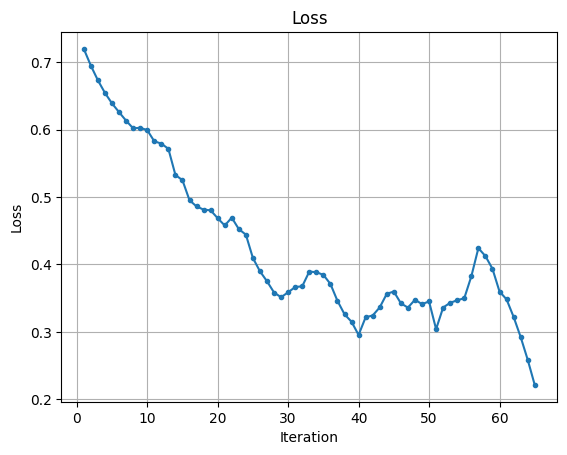

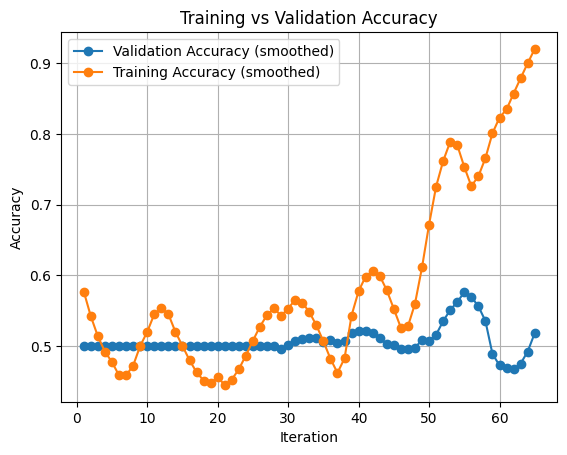

In [19]:
plotpic(data,smooth_window=10)

In [20]:
check_accuracy_final(loader_test, final_model, device, out=True)

Sample preds : [27.5%, 37.0%, 20.0%, 55.0%, 36.1%, 59.1%, 72.2%, 59.3%, 32.1%, 57.1%, 67.2%, 34.0%, 70.0%, 69.3%]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


0.6428571428571429

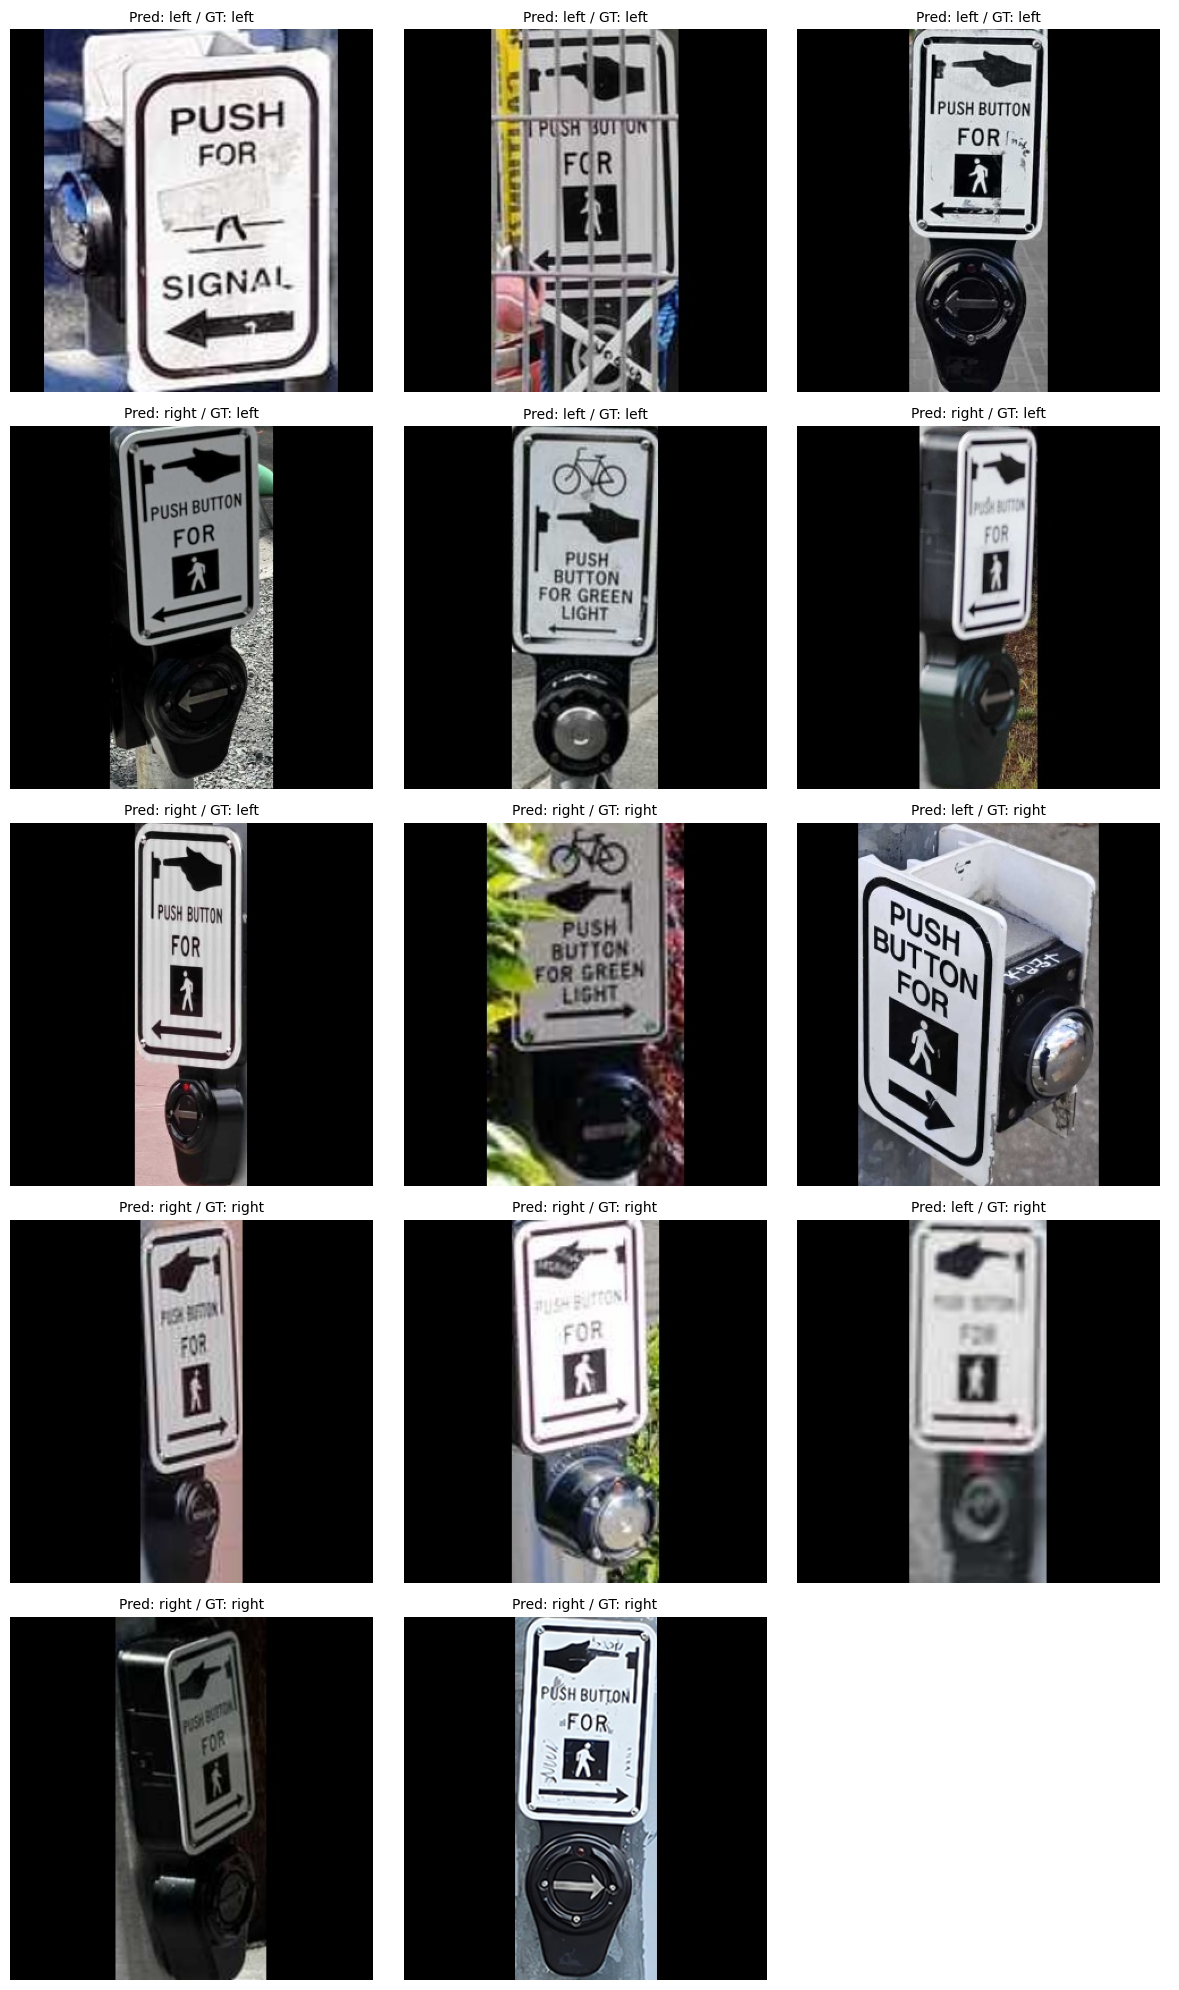

In [22]:
show_predictions_grid(loader_test, final_model, device, class_names=['left', 'right'], max_images=14, images_per_row=3)

Save model

In [23]:
torch.save(final_model.state_dict(), "tinyvit_wo_final.pth")